In [1]:
import os
import gc

os.chdir('../../')

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import json

# For CatBoost
from catboost import CatBoostRegressor

# For MAPIE Conformal
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieQuantileRegressor, MapieRegressor

# For metrics
from sklearn.metrics import mean_squared_error
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")



## Exploratory Data Analysis (EDA)
Explanation: We load the dataset, inspect its size and columns, convert dtypes,and visualize the price trends over time. We also check for missing values.

In [3]:
# Load the primary dataset
df = pd.read_csv("week_2/data/raw/sg-resale-flat-prices-2017-onwards.csv")

# Convert 'month' to datetime
df['month'] = pd.to_datetime(df['month'], format='%Y-%m')
df = df[df.month.dt.year > 2019]

# Inspect dataset size
print("Dataset shape:", df.shape)

# Show info
df.info()

Dataset shape: (117006, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 117006 entries, 64256 to 181261
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                117006 non-null  datetime64[ns]
 1   town                 117006 non-null  object        
 2   flat_type            117006 non-null  object        
 3   block                117006 non-null  object        
 4   street_name          117006 non-null  object        
 5   storey_range         117006 non-null  object        
 6   floor_area_sqm       117006 non-null  float64       
 7   flat_model           117006 non-null  object        
 8   lease_commence_date  117006 non-null  int64         
 9   remaining_lease      117006 non-null  object        
 10  resale_price         117006 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 10.7+ MB


In [4]:
# Identify date range
min_month = df['month'].min()
max_month = df['month'].max()
print(f"\nDate range: {min_month} to {max_month}")


Date range: 2020-01-01 00:00:00 to 2024-06-01 00:00:00


In [5]:
# Display a quick statistical summary (numerical features)
print("\nNumerical Features Summary:\n", df.describe())


Numerical Features Summary:
                                month  floor_area_sqm  lease_commence_date  \
count                         117006   117006.000000        117006.000000   
mean   2022-03-21 23:44:56.169427200       96.821397          1997.340342   
min              2020-01-01 00:00:00       31.000000          1966.000000   
25%              2021-03-01 00:00:00       82.000000          1985.000000   
50%              2022-03-01 00:00:00       93.000000          1997.000000   
75%              2023-04-01 00:00:00      112.000000          2014.000000   
max              2024-06-01 00:00:00      243.000000          2020.000000   
std                              NaN       23.888551            14.666418   

       resale_price  
count  1.170060e+05  
mean   5.302145e+05  
min    1.400000e+05  
25%    4.050000e+05  
50%    5.050000e+05  
75%    6.250000e+05  
max    1.588000e+06  
std    1.738752e+05  


In [6]:
# Display value counts for some key categorical features
print("\nValue Counts for 'town':\n", df["town"].value_counts(normalize=True).head())
print("\nValue Counts for 'flat_type':\n", df["flat_type"].value_counts(normalize=True).head())


Value Counts for 'town':
 town
SENGKANG     0.085662
PUNGGOL      0.080637
YISHUN       0.069193
TAMPINES     0.068877
WOODLANDS    0.067167
Name: proportion, dtype: float64

Value Counts for 'flat_type':
 flat_type
4 ROOM       0.426098
5 ROOM       0.249073
3 ROOM       0.233484
EXECUTIVE    0.070979
2 ROOM       0.019649
Name: proportion, dtype: float64


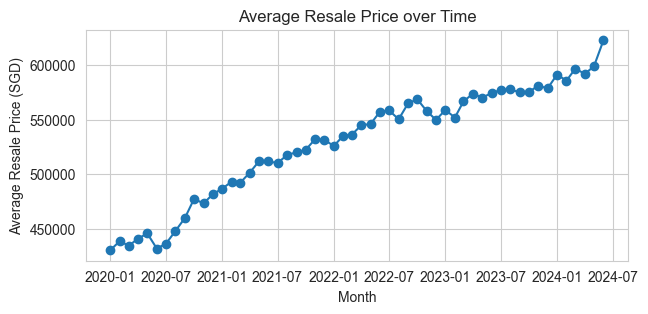

In [7]:
# Group by month to see average resale_price
price_trend = df.groupby('month')['resale_price'].mean().reset_index()

# Plot the trend of average resale price over time
plt.figure(figsize=(7, 3))
plt.plot(price_trend['month'], price_trend['resale_price'], marker='o')
plt.title("Average Resale Price over Time")
plt.xlabel("Month")
plt.ylabel("Average Resale Price (SGD)")
plt.show()

In [8]:
# Check missing values
print("\nMissing values per column:\n", df.isna().sum())


Missing values per column:
 month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64


## Correct for Inflation
We use an external price index dataset (sg_price_index.csv) to adjust the historical flat prices to a reference date (2023-12-31) and to project the index into the future (2024-01-01 to 2024-06-01).


In [9]:
# Load the price index dataset
df_index = pd.read_csv("week_2/data/raw/sg_price_index.csv")

# Assume 'quarter' is in format YYYY-QX, e.g., 2009-Q1, 2013-Q2
# Let's convert it to a datetime approximation by taking the start of that quarter.
# We'll store as a date for convenience. We also want a numeric representation 
# for polynomial fitting.
def quarter_to_date(q):
    # e.g., "2009-Q1" -> "2009-02" as a monthly approximation or "2009-01"
    year, qtr = q.split("-Q")
    month = (int(qtr)-1)*3 + 1  # Q1->1, Q2->4, Q3->7, Q4->10
    return pd.to_datetime(f"{year}-{month:02d}-01")

df_index['quarter_dt'] = df_index['quarter'].apply(quarter_to_date)

In [10]:
# We only need the period from 2017-01-01 to 2023-12-31 for actual values
# Let's create a reference index for 2023-12-31 or the closest available quarter
reference_date = pd.to_datetime("2023-12-31")
df_index = df_index[df_index.quarter_dt >= '2020-01-01'].copy()

# Filter the index data to the training period (for actual index usage)
mask_training_index = (df_index['quarter_dt'] >= '2020-01-01') & (df_index['quarter_dt'] <= reference_date)
df_index_train = df_index.loc[mask_training_index].copy()


# We'll define the reference index as the one closest to 2023-12-31
# If 2023-Q4 is in df_index, we can take that row's index value as reference.
df_index_train.sort_values('quarter_dt', inplace=True)
ref_value = df_index_train.iloc[-1]['index']

In [11]:
df_index.head()

,quarter,index,quarter_dt
120,2020-Q1,131.5,2020-01-01
121,2020-Q2,131.9,2020-04-01
122,2020-Q3,133.9,2020-07-01
123,2020-Q4,138.1,2020-10-01
124,2021-Q1,142.2,2021-01-01


In [13]:
# Merge index to main df by approximate quarter
# We'll create a quarter from 'month' to merge on.
# For simplicity, let's just approximate by quarter as well.
def month_to_quarter(dt):
    return f"{dt.year}-Q{(dt.month-1)//3 + 1}"


df['year_quarter'] = df['month'].apply(month_to_quarter)
df_index['year_quarter'] = df_index['quarter']  # same format

# Merge (left join on df), so each row in df gets the index of its quarter
df_merged = pd.merge(df, df_index[['year_quarter','index']], how='left', on='year_quarter')


df['year_quarter'] = df['month'].apply(month_to_quarter)
df_index['year_quarter'] = df_index['quarter']  # same format


# Merge (left join on df), so each row in df gets the index of its quarter
df_merged = pd.merge(df, df_index[['year_quarter','index']], how='left', on='year_quarter')

# Now create the corrected_price by adjusting to 2023-12-31 index level
# corrected_price = resale_price * (ref_value / current_index)
df_merged['corrected_price'] = df_merged['resale_price'] * (ref_value / df_merged['index'])



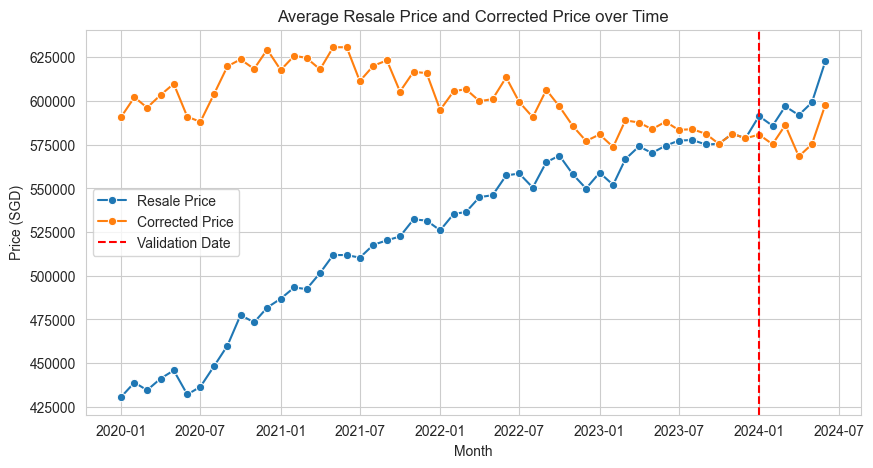

In [14]:
# Group by month to see average resale_price and corrected_price
price_trend_corrected = df_merged.groupby('month')[['resale_price', 'corrected_price']].mean().reset_index()
price_trend_corrected = price_trend_corrected[price_trend_corrected.month >= '2020-01-01']

# Plot the trend of average resale price and corrected price over time using seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(data=price_trend_corrected, x='month', y='resale_price', marker='o', label='Resale Price')
sns.lineplot(data=price_trend_corrected, x='month', y='corrected_price', marker='o', label='Corrected Price')
plt.title("Average Resale Price and Corrected Price over Time")
plt.xlabel("Month")
plt.ylabel("Price (SGD)")

# add vertical line for reference validation period (2023-12-31)
plt.axvline(reference_date, color='r', linestyle='--', label="Validation Date")
plt.legend()
plt.show()

In [15]:
# Next, let's fit a polynomial (quadratic) to the index in the training period 
# so we can extrapolate for 2024-01-01 to 2024-06-01. 
# We'll create a numeric time axis for df_index_train.

df_index_train['time_int'] = (df_index_train['quarter_dt'] - df_index_train['quarter_dt'].min()).dt.days
x_train_poly = df_index_train['time_int'].values
y_train_poly = df_index_train['index'].values

# Fit a 2nd-degree polynomial
poly_coeffs = np.polyfit(x_train_poly, y_train_poly, deg=2)
poly_model = np.poly1d(poly_coeffs)

# Let's define a function to get the 'predicted_index' for any date
def get_predicted_index(dt):
    # convert dt to the same scale
    time_int_ = (dt - df_index_train['quarter_dt'].min()).days
    return poly_model(time_int_)

# We'll create a 'predicted_index' for each row in df_merged
df_merged['predicted_index'] = df_merged['month'].apply(get_predicted_index)

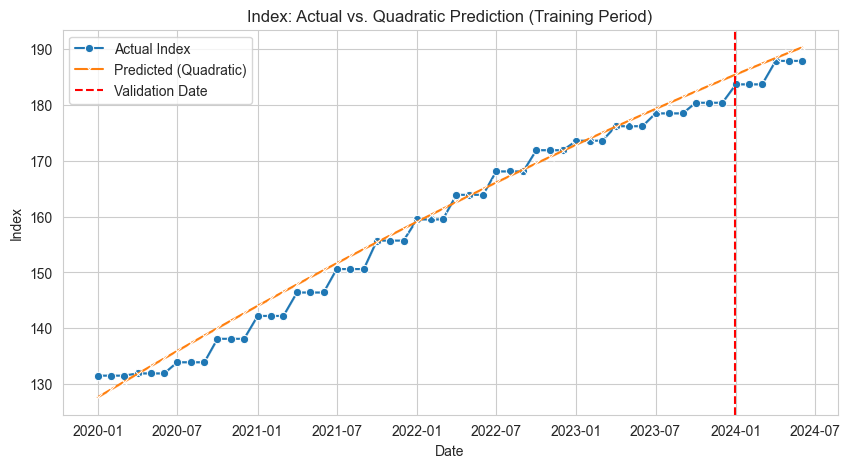

In [16]:
# Plot the actual index vs. predicted index for training period using seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_merged, x='month', y='index', label="Actual Index", marker='o')
sns.lineplot(data=df_merged, x='month', y='predicted_index', label="Predicted (Quadratic)", marker='x')
plt.title("Index: Actual vs. Quadratic Prediction (Training Period)")
plt.xlabel("Date")
plt.ylabel("Index")
# add vertical line for reference validation period (2023-12-31)
plt.axvline(reference_date, color='r', linestyle='--', label="Validation Date")
plt.legend()
plt.show()


In [17]:
# Update df_merged for further processing
df = df_merged.copy()
df.head(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year_quarter,index,corrected_price,predicted_index
0,2020-01-01,ANG MO KIO,3 ROOM,208,ANG MO KIO AVE 1,04 TO 06,73.0,New Generation,1976,55 years 07 months,265000.0,2020-Q1,131.5,363543.726236,127.629279
1,2020-01-01,ANG MO KIO,3 ROOM,307C,ANG MO KIO AVE 1,19 TO 21,70.0,Model A,2012,91 years 08 months,470000.0,2020-Q1,131.5,644775.665399,127.629279
2,2020-01-01,ANG MO KIO,3 ROOM,319,ANG MO KIO AVE 1,01 TO 03,73.0,New Generation,1977,56 years 04 months,230000.0,2020-Q1,131.5,315528.517110,127.629279
3,2020-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,New Generation,1976,55 years 03 months,280000.0,2020-Q1,131.5,384121.673004,127.629279
4,2020-01-01,ANG MO KIO,3 ROOM,556,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,59 years 01 month,220000.0,2020-Q1,131.5,301809.885932,127.629279


## Feature Engineering

We create additional features like price_per_sqm, date-based features,  numeric age features, and rolling window features (with 1-month shift)  grouped by location (town, town_street, town_street_block).

In [23]:
df.month.max()

Timestamp('2024-06-01 00:00:00')

In [24]:
# 1) Create price_per_sqm
df['price_per_sqm'] = df['resale_price'] / df['floor_area_sqm']
df['corrected_price_per_sqm'] = df['corrected_price'] / df['floor_area_sqm']

# 2) Date features: month number (1-12) and quarter (Q1-Q4)
df['month_num'] = df['month'].dt.month
df['quarter'] = df['month'].dt.quarter

# 3) Convert remaining_lease to numeric years
# Example: "61 years 04 months" -> 61.3333..., "61 years" -> 61
def parse_remaining_lease(lease_str):
    if pd.isna(lease_str):
        return np.nan
    # Typically looks like "61 years 04 months"
    parts = lease_str.split()
    years = 0
    months = 0
    for i, p in enumerate(parts):
        if p == 'years':
            years = float(parts[i-1])
        elif p == 'months':
            months = float(parts[i-1])
    return years + months/12.0

df['remaining_lease_years'] = df['remaining_lease'].apply(parse_remaining_lease)

# 4) lease_age = (month - lease_commence_date) in years
# For simplicity, let's approximate: lease_age = year(month) - lease_commence_date
# plus fraction of months
df['lease_age'] = (df['month'].dt.year - df['lease_commence_date']) + \
                  (df['month'].dt.month / 12.0)

In [55]:
# 5) Create location detail: town_street, town_street_block
df['town_street'] = df['town'] + "_" + df['street_name']
df['town_street_block'] = df['town'] + "_" + df['street_name'] + "_" + df['block']

# 6) Time-based window features (3-month, 6-month, 1-month), with shift(1)
# We'll define a helper function to generate these features for each grouping

def generate_rolling_features(data, group_col, windows=[1,3,6]):
    """
    For a given grouping column (e.g., 'town'),
    compute rolling average, std, max, min, and count
    of 'corrected_price_per_sqm' for 1, 3, and 6-month windows
    with a 1-month shift.
    """
    data = data.sort_values(by=['month'])  # ensure time order
    for w in windows:
        # Rolling window in months
        # We can group by [group_col] and apply a rolling window 
        # on monthly data. We'll approximate a rolling window with 
        # a groupby + rolling on a fixed window= w with min_periods=1.
        # SHIFT by 1 to avoid leakage of current month.
        
        # To handle monthly grouped data, we can do a groupby 
        # or we can just do rolling on time if it's strictly monthly. 
        # A simpler approach is to do a groupby on group_col, 
        # then sort by 'month', then rolling on window=w with shift=1.
        
        gp = df.groupby([group_col, 'month'])['corrected_price_per_sqm'].agg(['mean','std','max','min','count'])
        rolled=gp.rolling(w).agg({'mean': 'mean', 'std': 'mean', 'max': 'max', 'min': 'min', 'count': 'sum'}).shift(1)

        rolled.columns = [f'prior_{w}_{group_col}_{c}_price_per_sqm' for c in rolled.columns]
        rolled.reset_index(inplace=True)
        
        # Merge back
        data = pd.merge(data, rolled, on=[group_col, 'month'], how='left')
    return data

# Generate rolling features for different grouping columns
df = generate_rolling_features(df, 'town', windows=[1,3,6])
df = generate_rolling_features(df, 'town_street', windows=[1,3,6])
df = generate_rolling_features(df, 'town_street_block', windows=[1,3,6])


In [68]:
# Example final feature set (you can refine further):
non_features_list = ['month', 'lease_commence_date', 'remaining_lease', 'street_name', 
                     'town_street', 'town_street_block', 'year_quarter', 'block', 
                     'resale_price', 'index', 'corrected_price', 'price_per_sqm', 
                     'corrected_price_per_sqm', 'predicted_index']
                     
features_list = df.drop(columns=non_features_list).columns.tolist()

categorical_features = ['town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model']
# Cast categorical to type category
for c in categorical_features:
    df[c] = df[c].astype('category')


# Pritty print final features
print("Final Features:")
for i, f in enumerate(features_list):
    print(f"{i+1}. {f}")

Final Features:
1. town
2. flat_type
3. storey_range
4. floor_area_sqm
5. flat_model
6. year_quarter
7. month_num
8. quarter
9. remaining_lease_years
10. lease_age
11. prior_1_town_mean_price_per_sqm
12. prior_1_town_std_price_per_sqm
13. prior_1_town_max_price_per_sqm
14. prior_1_town_min_price_per_sqm
15. prior_1_town_count_price_per_sqm
16. prior_3_town_mean_price_per_sqm
17. prior_3_town_std_price_per_sqm
18. prior_3_town_max_price_per_sqm
19. prior_3_town_min_price_per_sqm
20. prior_3_town_count_price_per_sqm
21. prior_6_town_mean_price_per_sqm
22. prior_6_town_std_price_per_sqm
23. prior_6_town_max_price_per_sqm
24. prior_6_town_min_price_per_sqm
25. prior_6_town_count_price_per_sqm
26. prior_1_town_street_mean_price_per_sqm
27. prior_1_town_street_std_price_per_sqm
28. prior_1_town_street_max_price_per_sqm
29. prior_1_town_street_min_price_per_sqm
30. prior_1_town_street_count_price_per_sqm
31. prior_3_town_street_mean_price_per_sqm
32. prior_3_town_street_std_price_per_sqm
33. 

## Saving the feature engineered processed data to a parquet file

In [71]:
# Save the parquet data
df.to_parquet("week_2/data/processed/sg-resale-flat-prices-engineered.parquet")

# Save the features list as json
with open("week_2/data/processed/features_list.json", "w") as f:
    json.dump(features_list, f)